https://blog.amedama.jp/entry/imbalanced-data

In [1]:
from sklearn.datasets import make_classification

args = {
    'n_samples': 7000000,
    'n_features': 80,
    'n_informative': 3,
    'n_redundant': 0,
    'n_repeated': 0,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'weights': [0.99, 0.01],
    'random_state': 42,
}
X, y = make_classification(**args)

In [2]:
len(y[y == 0]), len(y[y == 1])

(6895786, 104214)

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'
%matplotlib inline

# plt.scatter(X[y == 0, 0], X[y == 0, 1])
# plt.scatter(X[y == 1, 0], X[y == 1, 1])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# LightGBM用の分割
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

[1]	valid_0's auc: 0.779419
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.8129
[3]	valid_0's auc: 0.81616
[4]	valid_0's auc: 0.823692
[5]	valid_0's auc: 0.824147
[6]	valid_0's auc: 0.824545
[7]	valid_0's auc: 0.825674
[8]	valid_0's auc: 0.825777
[9]	valid_0's auc: 0.825917
[10]	valid_0's auc: 0.827154
[11]	valid_0's auc: 0.827267
[12]	valid_0's auc: 0.827195
[13]	valid_0's auc: 0.827684
[14]	valid_0's auc: 0.828021
[15]	valid_0's auc: 0.828257
[16]	valid_0's auc: 0.828515
[17]	valid_0's auc: 0.829128
[18]	valid_0's auc: 0.82932
[19]	valid_0's auc: 0.830179
[20]	valid_0's auc: 0.830243
[21]	valid_0's auc: 0.830073
[22]	valid_0's auc: 0.830099
[23]	valid_0's auc: 0.830526
[24]	valid_0's auc: 0.830561
[25]	valid_0's auc: 0.830576
[26]	valid_0's auc: 0.830403
[27]	valid_0's auc: 0.830811
[28]	valid_0's auc: 0.830672
[29]	valid_0's auc: 0.830718
[30]	valid_0's auc: 0.829674
[31]	valid_0's auc: 0.829682
[32]	valid_0's auc: 0.830168
[33]	valid_0's auc: 0.8

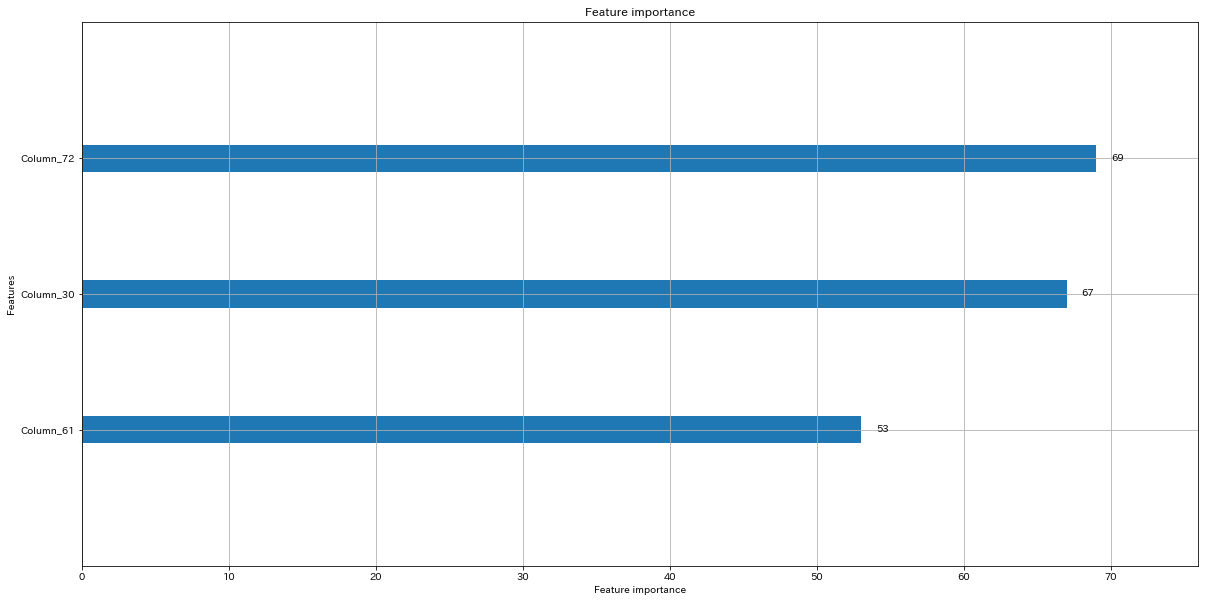

CPU times: user 1min 38s, sys: 6.57 s, total: 1min 44s
Wall time: 1min 3s


In [5]:
%%time
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'auc',
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

In [6]:
from sklearn.metrics import roc_auc_score

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.826888995685


# imbalanced-learn

In [7]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

In [8]:
len(X_resampled[y_resampled == 0, 0]), len(X_resampled[y_resampled == 1, 0])

(83342, 83342)

In [9]:
# plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1])
# plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1])

In [10]:
# LightGBM用の分割
X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)

[1]	valid_0's auc: 0.817245
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.822523
[3]	valid_0's auc: 0.823169
[4]	valid_0's auc: 0.823559
[5]	valid_0's auc: 0.823775
[6]	valid_0's auc: 0.824611
[7]	valid_0's auc: 0.824678
[8]	valid_0's auc: 0.824734
[9]	valid_0's auc: 0.824806
[10]	valid_0's auc: 0.824926
[11]	valid_0's auc: 0.825012
[12]	valid_0's auc: 0.825047
[13]	valid_0's auc: 0.826057
[14]	valid_0's auc: 0.82579
[15]	valid_0's auc: 0.826005
[16]	valid_0's auc: 0.826236
[17]	valid_0's auc: 0.826269
[18]	valid_0's auc: 0.826383
[19]	valid_0's auc: 0.826429
[20]	valid_0's auc: 0.826282
[21]	valid_0's auc: 0.826968
[22]	valid_0's auc: 0.827
[23]	valid_0's auc: 0.827015
[24]	valid_0's auc: 0.827037
[25]	valid_0's auc: 0.827313
[26]	valid_0's auc: 0.827356
[27]	valid_0's auc: 0.82711
[28]	valid_0's auc: 0.827182
[29]	valid_0's auc: 0.827209
[30]	valid_0's auc: 0.827299
[31]	valid_0's auc: 0.827188
[32]	valid_0's auc: 0.826803
[33]	valid_0's auc: 0.82

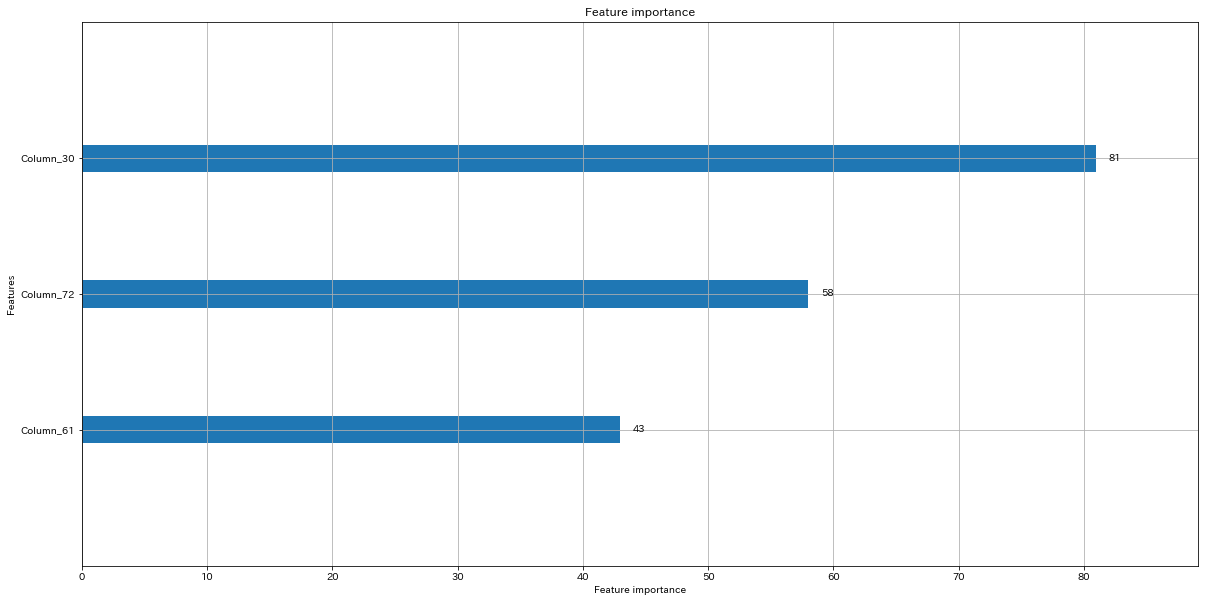

CPU times: user 5.32 s, sys: 369 ms, total: 5.69 s
Wall time: 3.29 s


In [11]:
%%time
lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'auc',
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

In [12]:
# テストデータを予測する
y_pred_r = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred_r)
print(auc)

0.828528984506


# CV

In [13]:
%%time
from sklearn.model_selection import StratifiedKFold

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'auc',
}

models = []

skf = StratifiedKFold(n_splits=5, random_state=123)
for train_index, valid_index in skf.split(X, y):
    X_train2, X_valid = X[train_index], X[valid_index]
    y_train2, y_valid = y[train_index], y[valid_index]
    
    lgb_train = lgb.Dataset(X_train2, y_train2)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    models.append(model)

[1]	valid_0's auc: 0.779897
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.815134
[3]	valid_0's auc: 0.815521
[4]	valid_0's auc: 0.818296
[5]	valid_0's auc: 0.818403
[6]	valid_0's auc: 0.819259
[7]	valid_0's auc: 0.821359
[8]	valid_0's auc: 0.826378
[9]	valid_0's auc: 0.826674
[10]	valid_0's auc: 0.826836
[11]	valid_0's auc: 0.82745
[12]	valid_0's auc: 0.827767
[13]	valid_0's auc: 0.828395
[14]	valid_0's auc: 0.828299
[15]	valid_0's auc: 0.829284
[16]	valid_0's auc: 0.829539
[17]	valid_0's auc: 0.829927
[18]	valid_0's auc: 0.829984
[19]	valid_0's auc: 0.830024
[20]	valid_0's auc: 0.829891
[21]	valid_0's auc: 0.830315
[22]	valid_0's auc: 0.830065
[23]	valid_0's auc: 0.830074
[24]	valid_0's auc: 0.83024
[25]	valid_0's auc: 0.830244
[26]	valid_0's auc: 0.830335
[27]	valid_0's auc: 0.830322
[28]	valid_0's auc: 0.83032
[29]	valid_0's auc: 0.830478
[30]	valid_0's auc: 0.830655
[31]	valid_0's auc: 0.831193
[32]	valid_0's auc: 0.830978
[33]	valid_0's auc: 0.

In [14]:
# テストデータを予測する
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))

In [15]:
y_pred_cv = y_preds[len(y_preds) - 1]
for i in range(len(y_preds) - 1):
    y_pred_cv += y_preds[i]
y_pred_cv /= len(y_preds)

In [16]:
(roc_auc_score(y_test, y_preds[0]),
roc_auc_score(y_test, y_preds[1]),
roc_auc_score(y_test, y_preds[2]),
roc_auc_score(y_test, y_preds[3]),
roc_auc_score(y_test, y_preds[4]))

(0.83022342874959876,
 0.82879111716786669,
 0.82957641293490625,
 0.83098942035062295,
 0.83062657174601773)

In [17]:
# auc を計算する
auc = roc_auc_score(y_test, y_pred_cv)
print(auc)

0.830626571746
